## __PRML Project__ 
### __Handwritten Digit Recognition__
___
`Navneet Meena B21CS051`
`Vishal Jharwal B21EE077`
`Harsh Nawal B21AI015`
`Rohan Kumar Duddeda B21AI031`
`Tushar Saini B21EE071`


In [7]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

ModuleNotFoundError: No module named 'torch'

#### __Model Settings__

In [ ]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 5

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
GRAYSCALE = True

#### __MNIST Dataset__

In [ ]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 9912422/9912422 [00:00<00:00, 113579943.73it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56871217.76it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34457477.51it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20223491.26it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


#### __Dataset Visualisation__

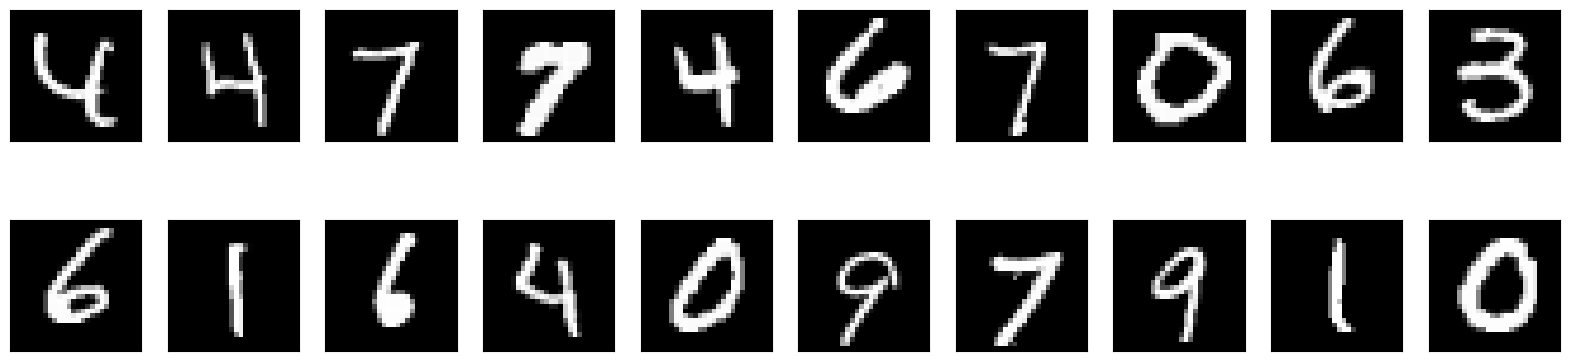

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 5))

for i, (features, targets) in enumerate(train_loader):
  if(i==20):
    break
  axes[i//10][i%10].imshow(features[0].view(28, 28, -1), cmap="gray")
  axes[i//10][i%10].set_xticks([])
  axes[i//10][i%10].set_yticks([])

#### __Resnet 18 Model__
The following code cell that implements the ResNet-18 architecture.

In [ ]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock,
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [ ]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [5]:
!pip install torchview

  Obtaining dependency information for torchview from https://files.pythonhosted.org/packages/84/a8/09cccd76a6ac4d021354bafbb9b330fd1763b5cace99aa6af47b8d27dc87/torchview-0.2.6-py3-none-any.whl.metadata



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


#### __Model Architecture visualisation__

In [6]:
import torchvision
from torchview import draw_graph

features, targets = None, None
for batch_idx, (feat, trgt) in enumerate(test_loader):
    features = feat
    targets = trgt
    break


model_graph = draw_graph(model, input_data=feat, expand_nested = False, graph_dir="./", save_graph=True)
model_graph.visual_graph


ModuleNotFoundError: No module named 'torchvision'

#### __Training__

In [ ]:
accuracy = []
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


start_time = time.time()
for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))



    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS,
              compute_accuracy(model, train_loader)))
        accuracy.append(compute_accuracy(model, train_loader))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 0000/0469 | Cost: 2.6379
Epoch: 001/005 | Batch 0050/0469 | Cost: 0.1730
Epoch: 001/005 | Batch 0100/0469 | Cost: 0.0560
Epoch: 001/005 | Batch 0150/0469 | Cost: 0.0501
Epoch: 001/005 | Batch 0200/0469 | Cost: 0.1140
Epoch: 001/005 | Batch 0250/0469 | Cost: 0.2180
Epoch: 001/005 | Batch 0300/0469 | Cost: 0.0326
Epoch: 001/005 | Batch 0350/0469 | Cost: 0.0826
Epoch: 001/005 | Batch 0400/0469 | Cost: 0.0582
Epoch: 001/005 | Batch 0450/0469 | Cost: 0.0068
Epoch: 001/005 | Train: 97.892%
Time elapsed: 16.45 min
Epoch: 002/005 | Batch 0000/0469 | Cost: 0.0366
Epoch: 002/005 | Batch 0050/0469 | Cost: 0.0672
Epoch: 002/005 | Batch 0100/0469 | Cost: 0.0160
Epoch: 002/005 | Batch 0150/0469 | Cost: 0.2068
Epoch: 002/005 | Batch 0200/0469 | Cost: 0.1393
Epoch: 002/005 | Batch 0250/0469 | Cost: 0.0118
Epoch: 002/005 | Batch 0300/0469 | Cost: 0.0461
Epoch: 002/005 | Batch 0350/0469 | Cost: 0.0910
Epoch: 002/005 | Batch 0400/0469 | Cost: 0.0187
Epoch: 002/005 | Batch 0450/0469

#### __Evaluation__

In [ ]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 98.82%


#### __Visualisation of Prediciton on Test Set__

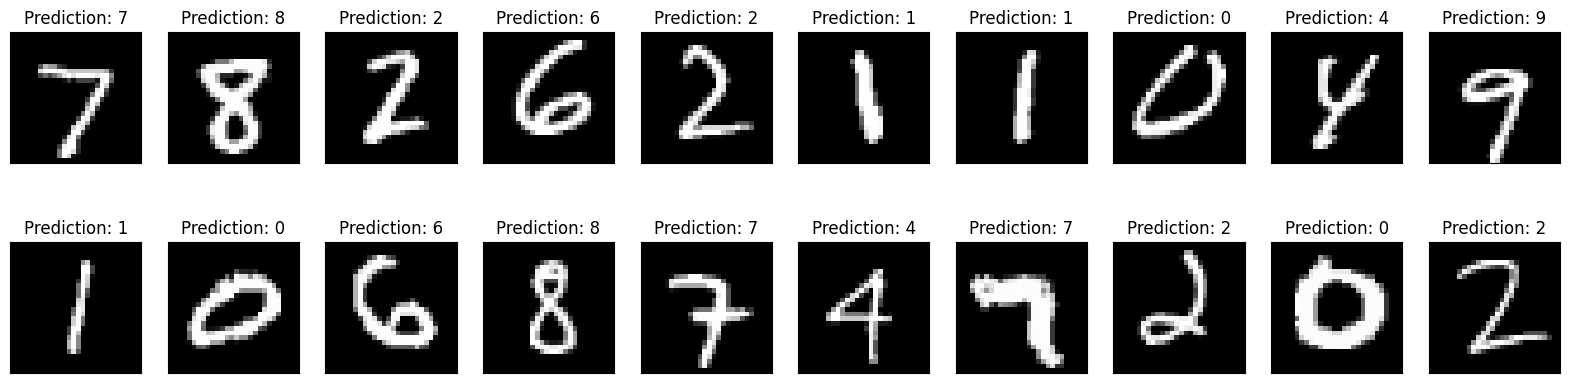

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 5))

for i, (features, targets) in enumerate(test_loader):
  if(i==20):
    break
  model.eval()
  logits, probas = model(features[0, None])
  pred = torch.argmax(probas[0], dim=-1).item()
  axes[i//10][i%10].imshow(features[0].view(28, 28, -1), cmap="grey")
  axes[i//10][i%10].set_title(f"Prediction: {pred}")

  axes[i//10][i%10].set_xticks([])
  axes[i//10][i%10].set_yticks([])